In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

#contour = load_contour().to(device)
#contour.shape

torch.Size([3, 386, 3, 64, 64])

In [2]:
T = 500
beta = torch.linspace(10e-4, 0.025, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0014, device='cuda:0')

In [3]:
alpha_

tensor([0.9990, 0.9980, 0.9969, 0.9957, 0.9945, 0.9933, 0.9920, 0.9907, 0.9893,
        0.9879, 0.9864, 0.9849, 0.9834, 0.9818, 0.9801, 0.9784, 0.9767, 0.9749,
        0.9731, 0.9713, 0.9694, 0.9674, 0.9654, 0.9634, 0.9613, 0.9592, 0.9570,
        0.9548, 0.9526, 0.9503, 0.9480, 0.9456, 0.9432, 0.9408, 0.9383, 0.9358,
        0.9332, 0.9306, 0.9280, 0.9253, 0.9226, 0.9199, 0.9171, 0.9143, 0.9114,
        0.9086, 0.9056, 0.9027, 0.8997, 0.8967, 0.8936, 0.8905, 0.8874, 0.8843,
        0.8811, 0.8779, 0.8746, 0.8714, 0.8681, 0.8647, 0.8614, 0.8580, 0.8546,
        0.8511, 0.8477, 0.8442, 0.8406, 0.8371, 0.8335, 0.8299, 0.8263, 0.8226,
        0.8190, 0.8153, 0.8116, 0.8078, 0.8041, 0.8003, 0.7965, 0.7927, 0.7888,
        0.7849, 0.7811, 0.7772, 0.7733, 0.7693, 0.7654, 0.7614, 0.7574, 0.7534,
        0.7494, 0.7454, 0.7413, 0.7373, 0.7332, 0.7291, 0.7250, 0.7209, 0.7168,
        0.7127, 0.7085, 0.7044, 0.7002, 0.6960, 0.6919, 0.6877, 0.6835, 0.6793,
        0.6751, 0.6709, 0.6666, 0.6624, 

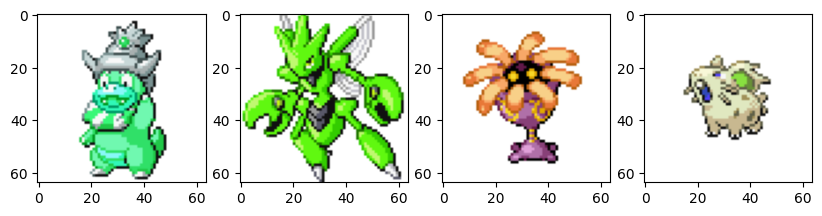

In [4]:
transform = v2.Compose([
    v2.ColorJitter(),
    v2.RandomChannelPermutation(),
    v2.RandomGrayscale(p = 0.1),
    #v2.GaussianBlur(kernel_size=9, sigma=(1,1))
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
pimages.min(), pimages.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

In [6]:
def isigmoid(x):
    eps = 0.1
    return torch.log(x + eps) - torch.log(1 - x + eps)


In [7]:
model = UNet(3, 3).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    #cont = contour[1, 151]
    x = torch.randn((3,64,64), device=device)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn((3,64,64), device=device)

        #xn = torch.cat([x, cont], dim=0)
        e = model(x[None], tt)[0] * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])

        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
        
    plot_image(torch.sigmoid(x))
    plt.show()

    model.train()

  0%|          | 0/100001 [00:00<?, ?it/s]

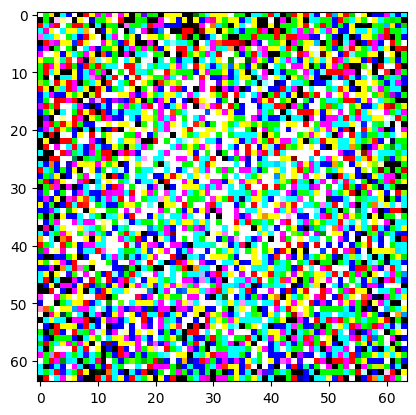

0.10455054:   0%|          | 499/100001 [00:43<2:08:36, 12.90it/s]

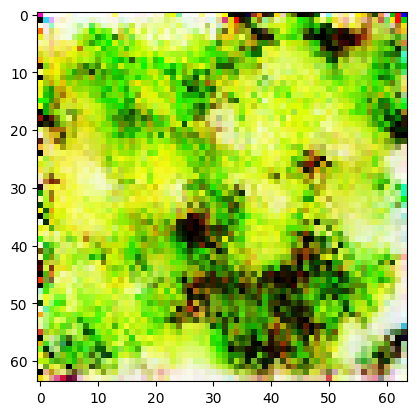

0.13224819:   1%|          | 999/100001 [01:24<2:07:45, 12.92it/s] 

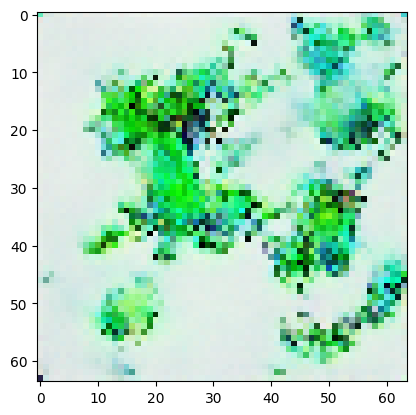

0.09903233:   1%|▏         | 1499/100001 [02:06<2:07:12, 12.91it/s] 

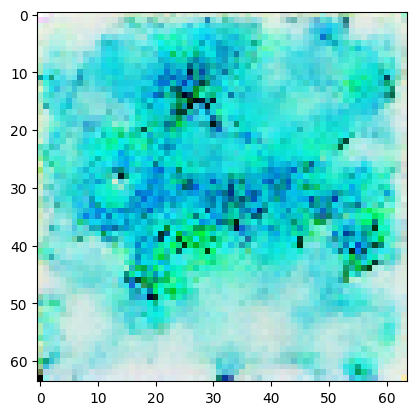

0.06716515:   2%|▏         | 1999/100001 [02:48<2:06:22, 12.92it/s] 

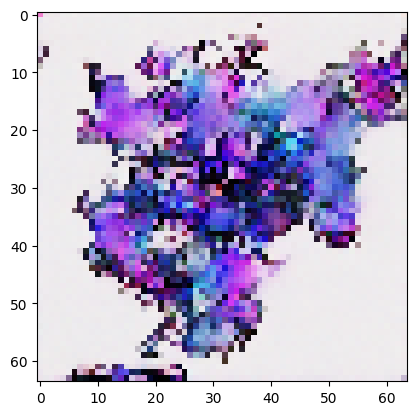

0.10532200:   2%|▏         | 2499/100001 [03:30<2:05:41, 12.93it/s] 

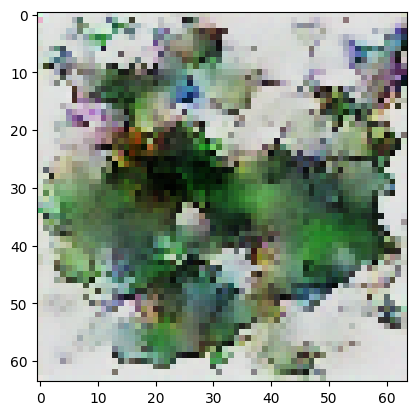

0.07228628:   3%|▎         | 2999/100001 [04:11<2:05:07, 12.92it/s] 

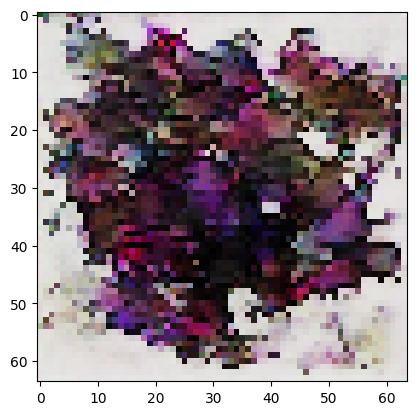

0.05417390:   3%|▎         | 3499/100001 [04:53<2:04:46, 12.89it/s] 

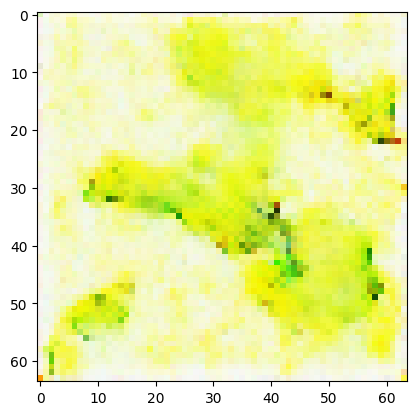

0.04475117:   4%|▍         | 3999/100001 [05:35<2:04:14, 12.88it/s] 

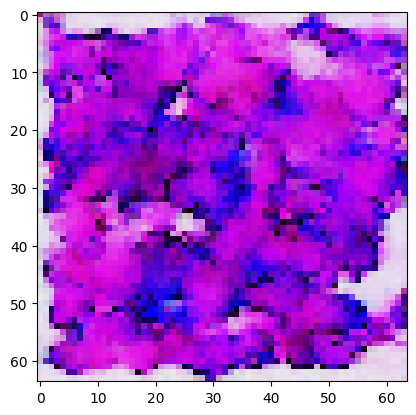

0.06413867:   4%|▍         | 4499/100001 [06:17<2:03:15, 12.91it/s] 

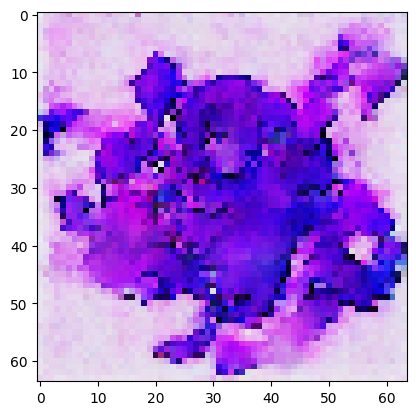

0.06816686:   5%|▍         | 4999/100001 [06:58<2:03:21, 12.84it/s] 

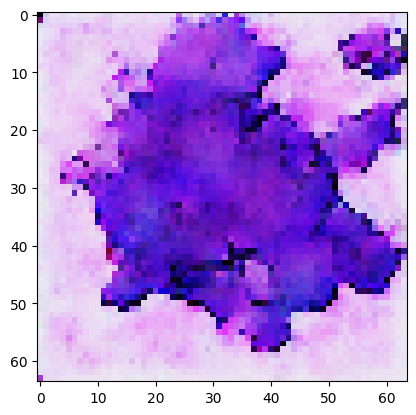

0.05023113:   5%|▌         | 5499/100001 [07:40<2:02:01, 12.91it/s] 

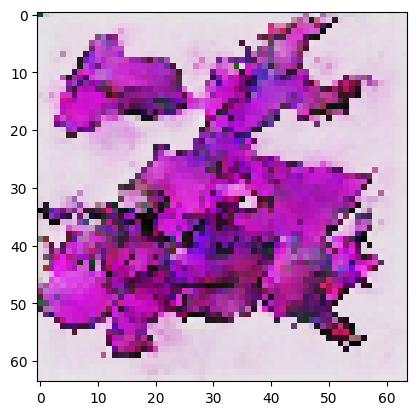

0.02697447:   6%|▌         | 5999/100001 [08:22<2:01:18, 12.92it/s] 

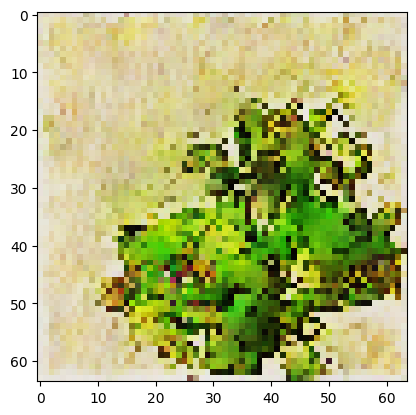

0.06725509:   6%|▋         | 6499/100001 [09:04<2:00:26, 12.94it/s] 

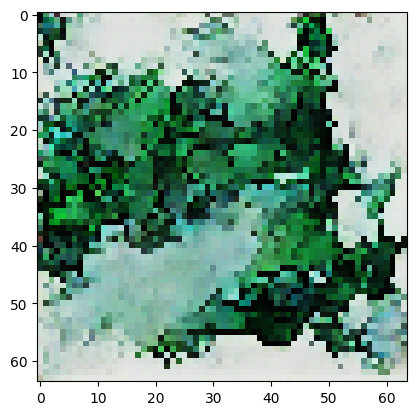

0.04275572:   7%|▋         | 6999/100001 [09:45<2:00:03, 12.91it/s] 

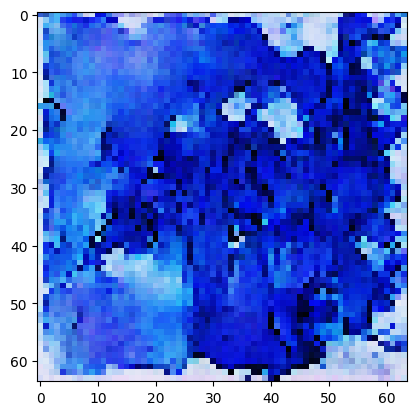

0.08395504:   7%|▋         | 7499/100001 [10:27<1:59:35, 12.89it/s] 

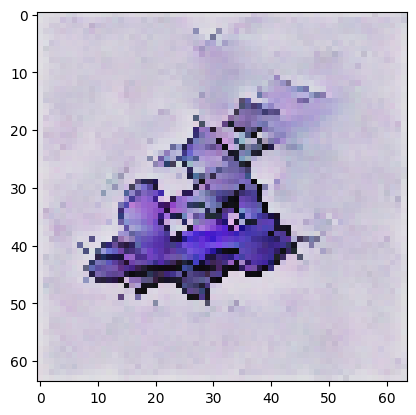

0.05263063:   8%|▊         | 7999/100001 [11:09<1:58:43, 12.92it/s] 

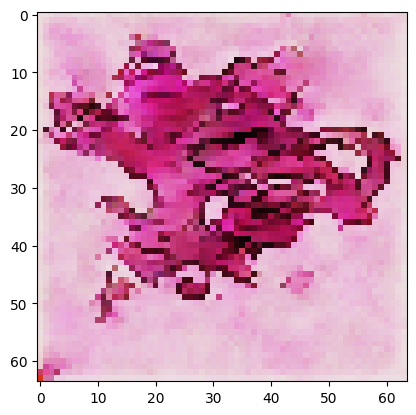

0.05591638:   8%|▊         | 8499/100001 [11:51<1:58:22, 12.88it/s] 

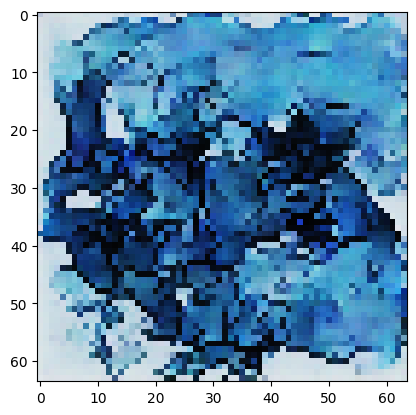

0.03626642:   9%|▉         | 8999/100001 [12:32<1:57:55, 12.86it/s] 

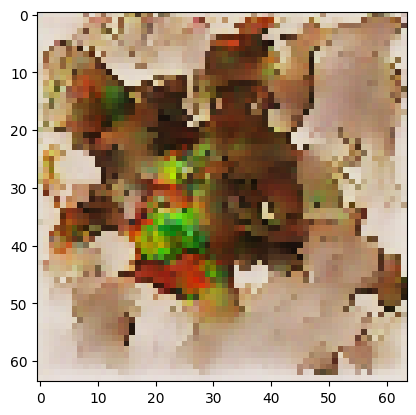

0.05351555:   9%|▉         | 9499/100001 [13:14<1:56:55, 12.90it/s] 

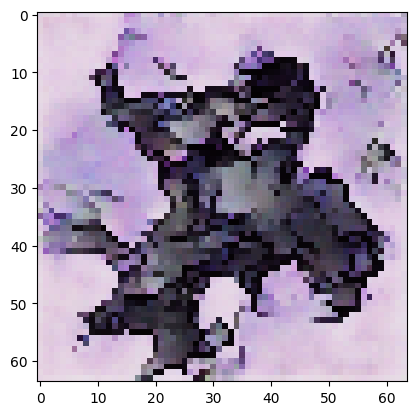

0.06315240:  10%|▉         | 9999/100001 [13:56<1:56:31, 12.87it/s] 

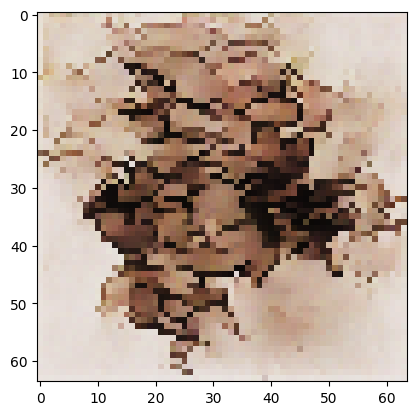

0.03790430:  10%|█         | 10499/100001 [14:38<1:55:30, 12.91it/s] 

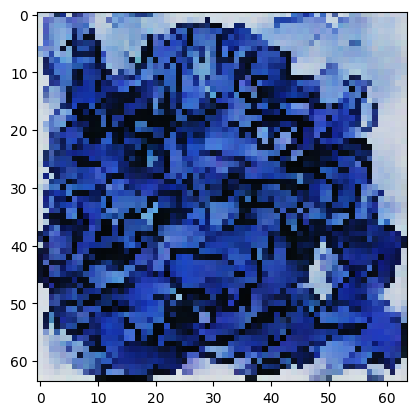

0.06407057:  11%|█         | 10999/100001 [15:20<1:55:16, 12.87it/s] 

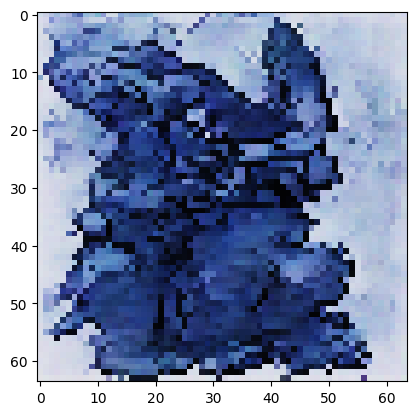

0.04893073:  11%|█▏        | 11499/100001 [16:01<1:55:14, 12.80it/s] 

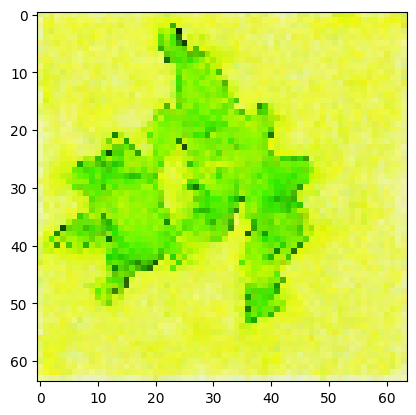

0.04980581:  12%|█▏        | 11999/100001 [16:43<1:54:08, 12.85it/s] 

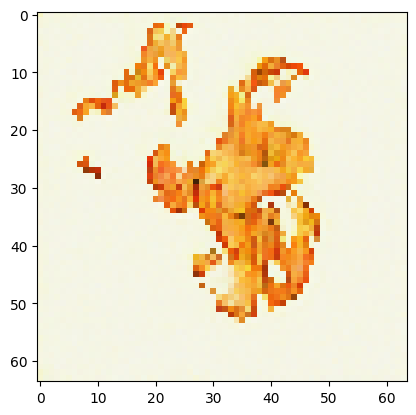

0.07996731:  12%|█▏        | 12499/100001 [17:25<1:53:20, 12.87it/s] 

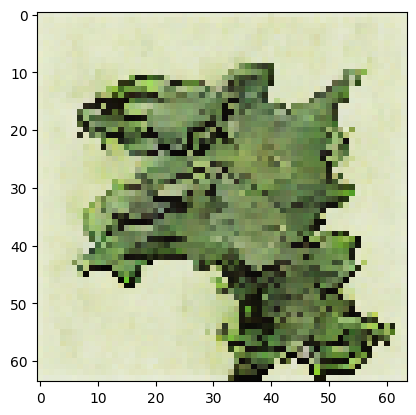

0.03663318:  13%|█▎        | 12999/100001 [18:07<1:52:33, 12.88it/s] 

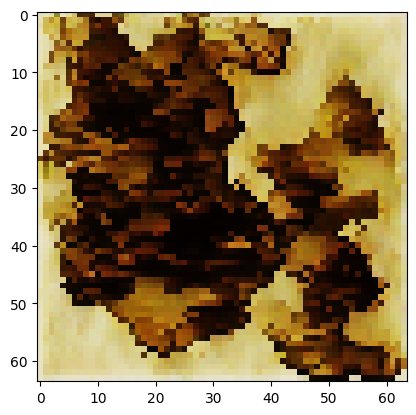

0.03412829:  13%|█▎        | 13499/100001 [18:49<1:51:35, 12.92it/s] 

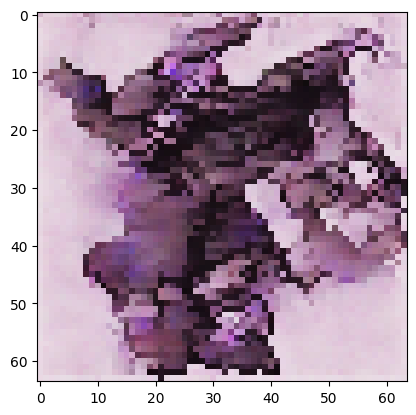

0.05513315:  14%|█▍        | 13999/100001 [19:31<1:50:43, 12.94it/s] 

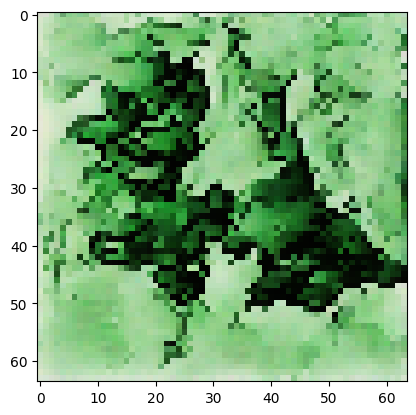

0.03581582:  14%|█▍        | 14499/100001 [20:13<1:50:55, 12.85it/s] 

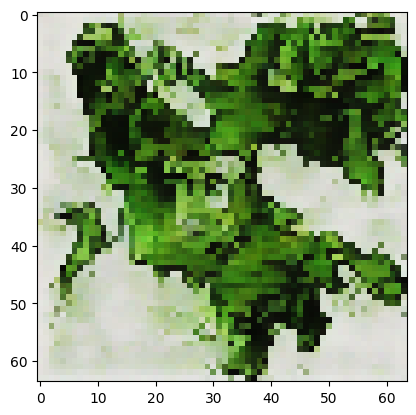

0.04070538:  15%|█▍        | 14999/100001 [20:55<2:11:55, 10.74it/s] 

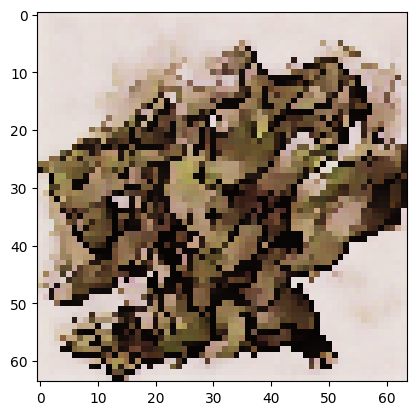

0.03212991:  15%|█▌        | 15499/100001 [21:38<1:49:18, 12.88it/s] 

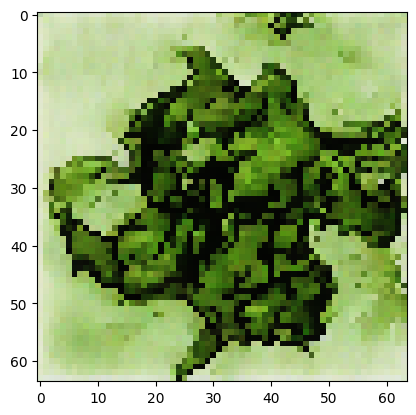

0.04640280:  16%|█▌        | 15999/100001 [22:20<1:48:54, 12.85it/s] 

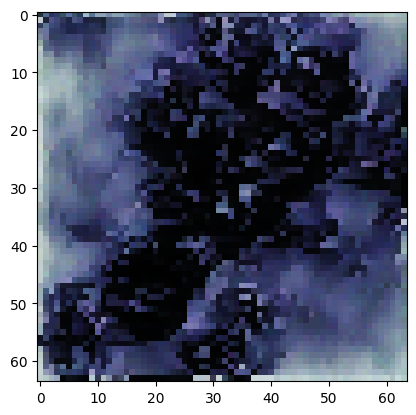

0.04188704:  16%|█▋        | 16499/100001 [23:01<1:47:51, 12.90it/s] 

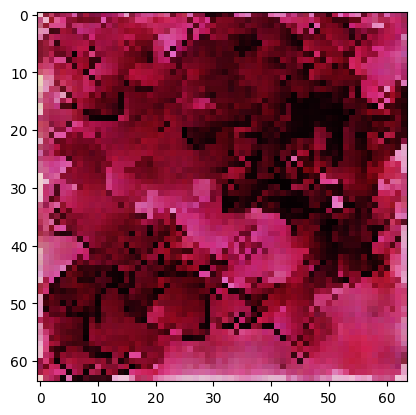

0.06005380:  17%|█▋        | 16999/100001 [23:43<1:47:04, 12.92it/s] 

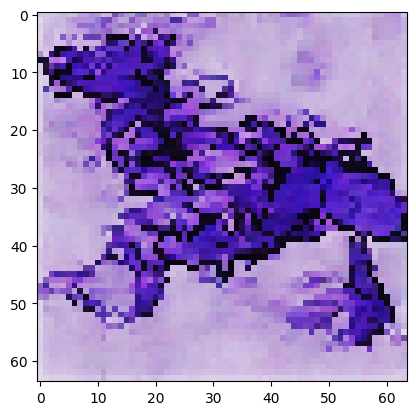

0.04324363:  17%|█▋        | 17499/100001 [24:25<1:47:08, 12.83it/s] 

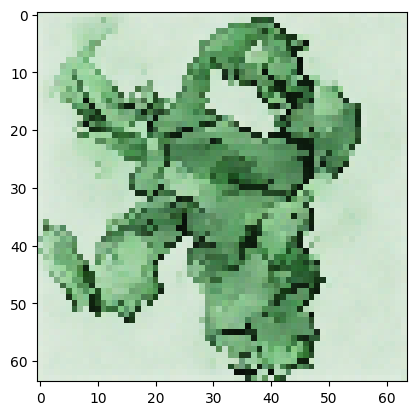

0.02748223:  18%|█▊        | 17999/100001 [25:07<1:45:54, 12.90it/s] 

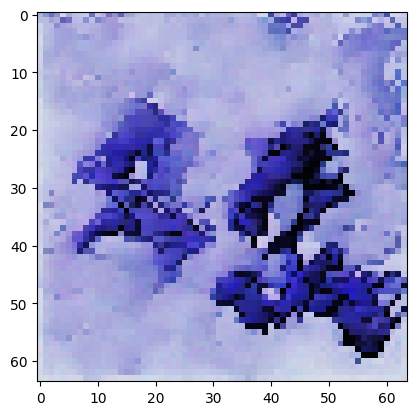

0.03473805:  18%|█▊        | 18499/100001 [25:48<1:45:22, 12.89it/s] 

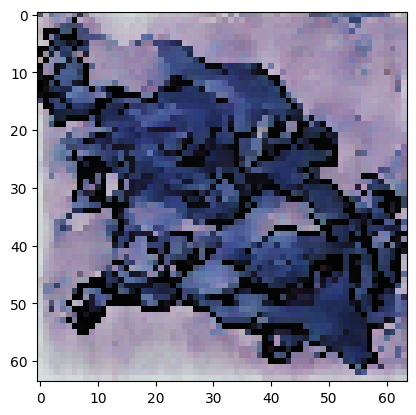

0.03880212:  19%|█▉        | 18999/100001 [26:30<1:44:31, 12.91it/s] 

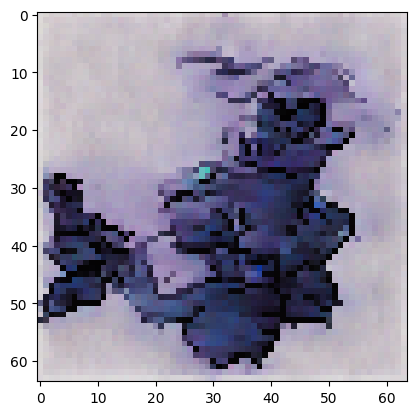

0.04186891:  19%|█▉        | 19499/100001 [27:12<1:43:58, 12.90it/s] 

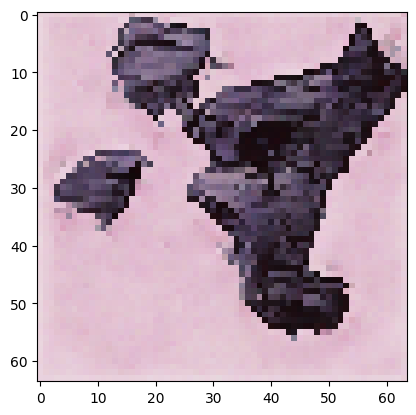

0.03789520:  20%|█▉        | 19999/100001 [27:54<1:43:15, 12.91it/s] 

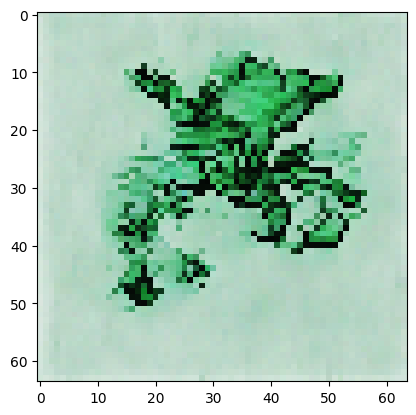

0.04063067:  20%|██        | 20499/100001 [28:35<1:42:50, 12.88it/s] 

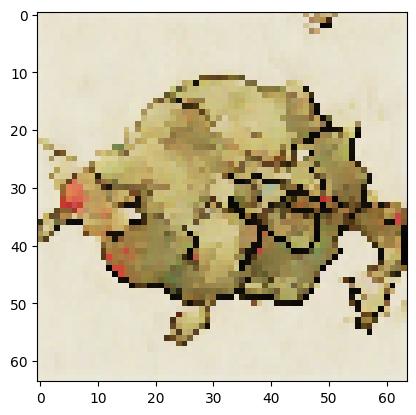

0.02869466:  21%|██        | 20999/100001 [29:17<1:41:57, 12.91it/s] 

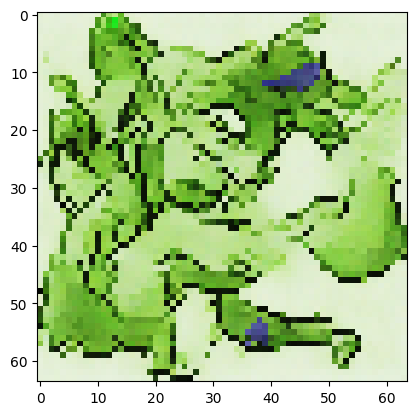

0.03001855:  21%|██▏       | 21499/100001 [29:59<1:41:33, 12.88it/s] 

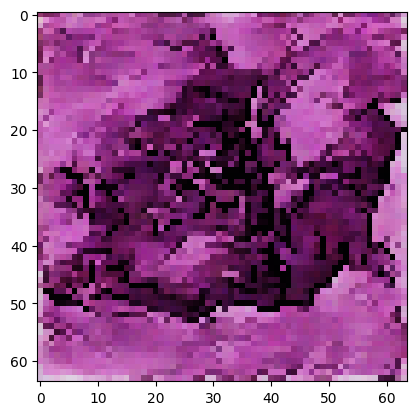

0.05515207:  22%|██▏       | 21999/100001 [30:41<1:40:34, 12.92it/s] 

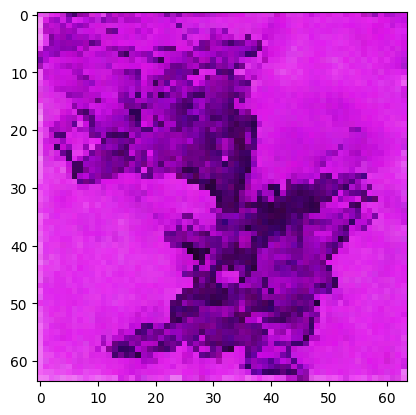

0.05605466:  22%|██▏       | 22499/100001 [31:22<1:40:12, 12.89it/s] 

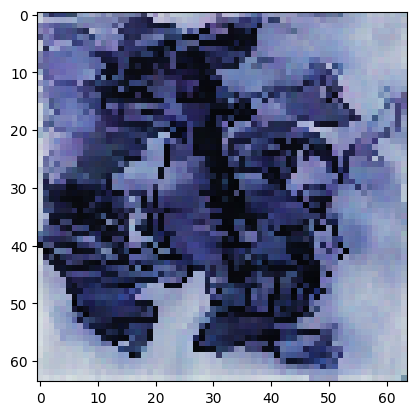

0.06401636:  23%|██▎       | 22999/100001 [32:04<1:39:09, 12.94it/s] 

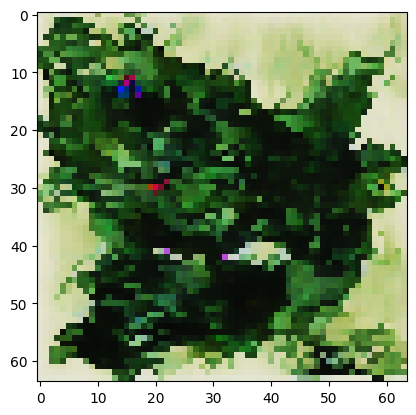

0.03432254:  23%|██▎       | 23499/100001 [32:46<1:38:51, 12.90it/s] 

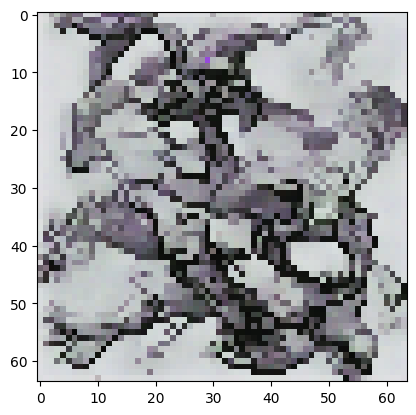

0.03802606:  24%|██▍       | 23999/100001 [33:28<1:38:00, 12.92it/s] 

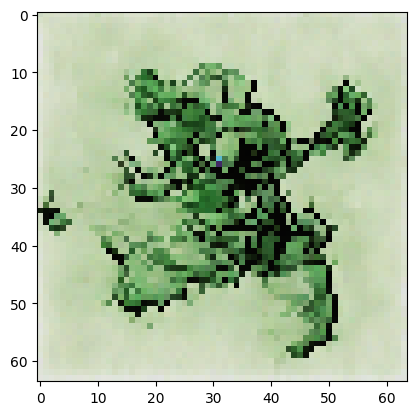

0.02813577:  24%|██▍       | 24499/100001 [34:09<1:37:57, 12.85it/s] 

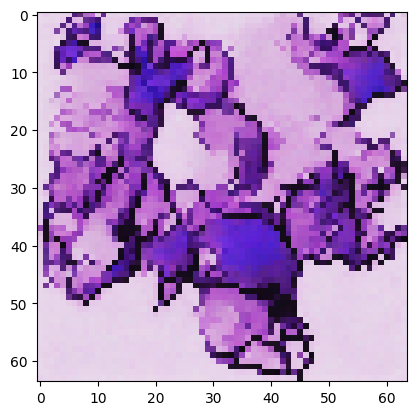

0.02519858:  25%|██▍       | 24999/100001 [34:51<1:37:01, 12.88it/s] 

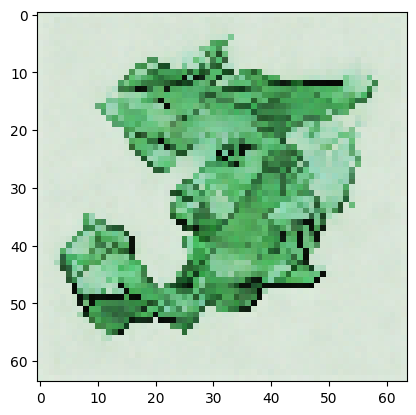

0.01404161:  25%|██▌       | 25499/100001 [35:33<1:36:16, 12.90it/s] 

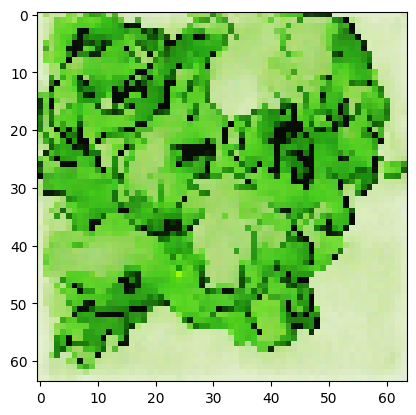

0.02595245:  26%|██▌       | 25999/100001 [36:15<1:35:28, 12.92it/s] 

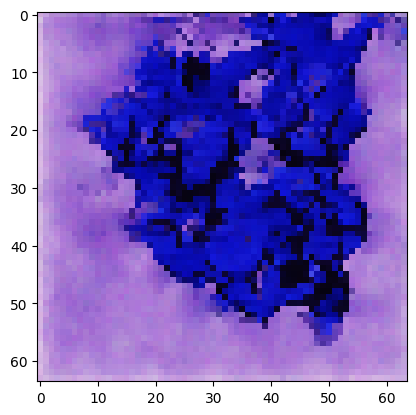

0.03497903:  26%|██▋       | 26499/100001 [36:57<1:34:47, 12.92it/s] 

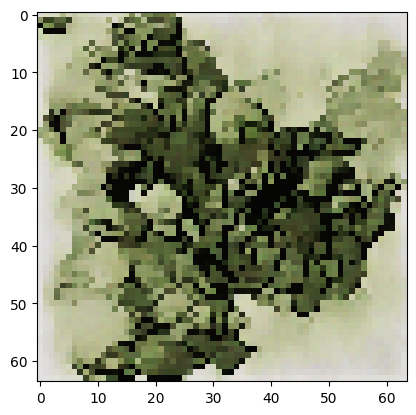

0.07638067:  27%|██▋       | 26999/100001 [37:38<1:34:22, 12.89it/s] 

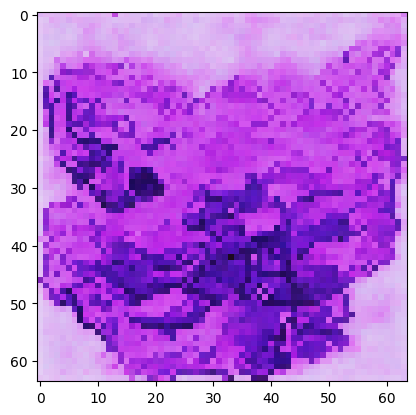

0.03634123:  27%|██▋       | 27499/100001 [38:20<1:33:45, 12.89it/s] 

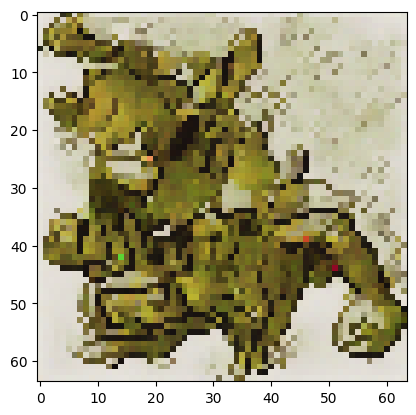

0.02237612:  28%|██▊       | 27999/100001 [39:02<1:33:00, 12.90it/s] 

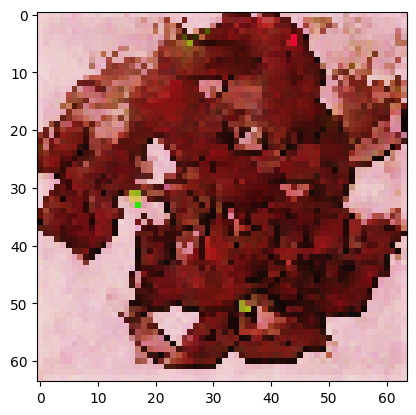

0.03662018:  28%|██▊       | 28499/100001 [39:44<1:32:34, 12.87it/s] 

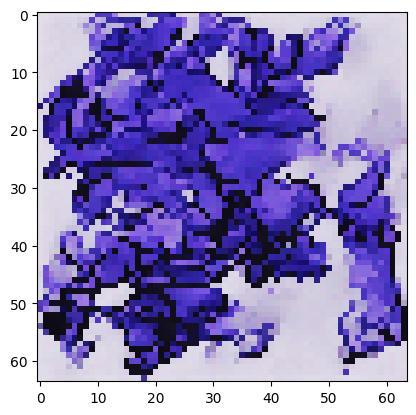

0.04514922:  29%|██▉       | 28999/100001 [40:26<1:31:40, 12.91it/s] 

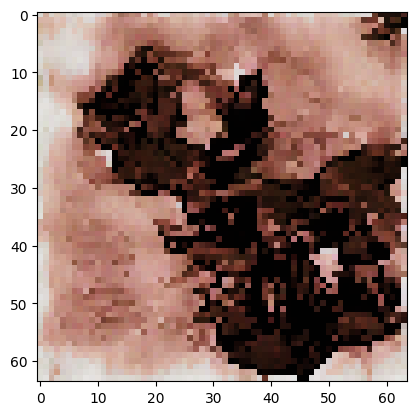

0.02923734:  29%|██▉       | 29499/100001 [41:08<1:31:10, 12.89it/s] 

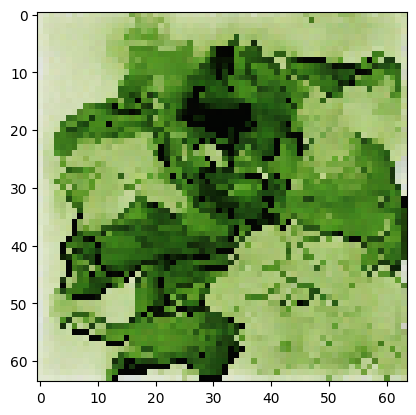

0.04407218:  30%|██▉       | 29999/100001 [41:50<1:31:40, 12.73it/s] 

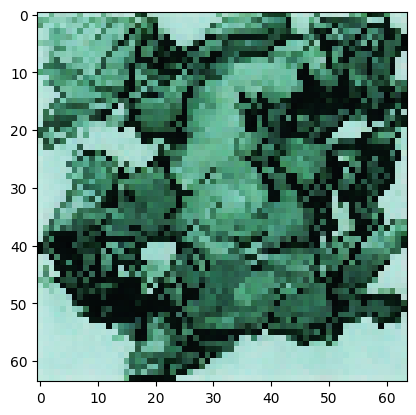

0.02314287:  30%|███       | 30499/100001 [42:33<1:29:37, 12.92it/s] 

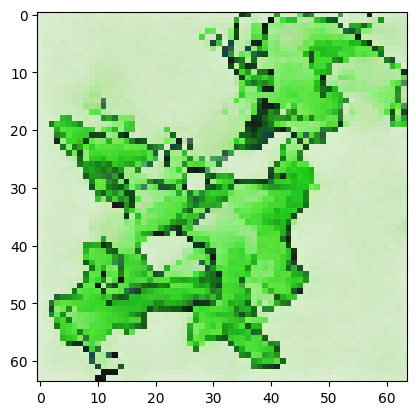

0.03675140:  31%|███       | 30999/100001 [43:15<1:29:08, 12.90it/s] 

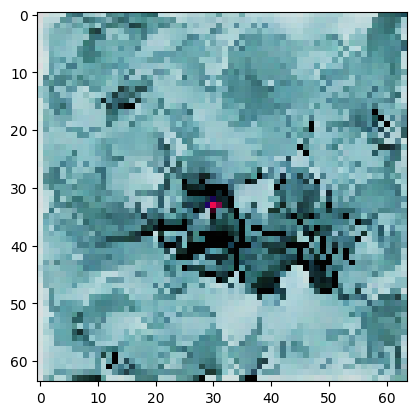

0.01819670:  31%|███▏      | 31499/100001 [43:56<1:28:22, 12.92it/s] 

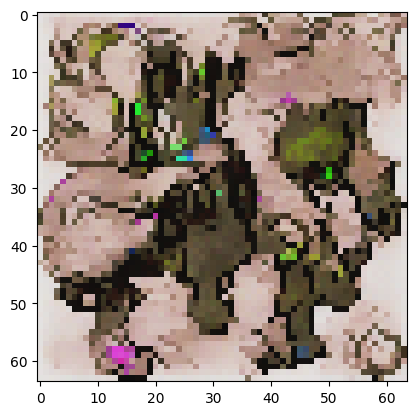

0.03076639:  32%|███▏      | 31999/100001 [44:38<1:27:52, 12.90it/s] 

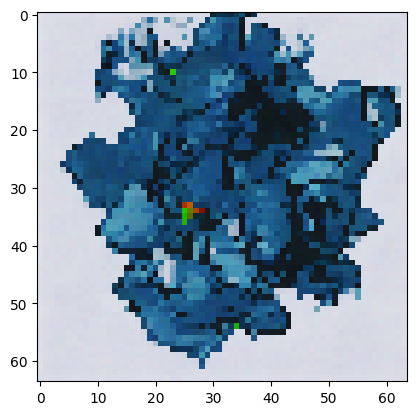

0.02048323:  32%|███▏      | 32499/100001 [45:20<1:27:04, 12.92it/s]

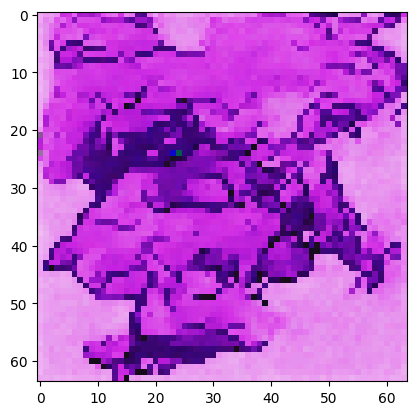

0.04962938:  33%|███▎      | 32999/100001 [46:02<1:26:36, 12.89it/s]

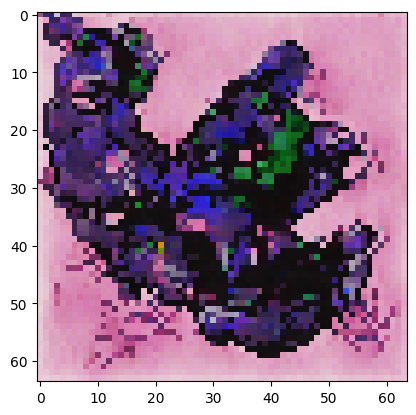

0.02555862:  33%|███▎      | 33499/100001 [46:43<1:25:54, 12.90it/s]

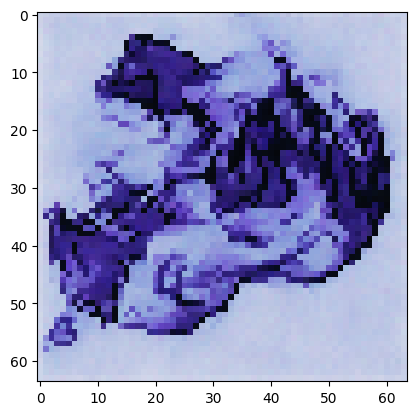

0.03061959:  34%|███▍      | 33999/100001 [47:25<1:25:07, 12.92it/s]

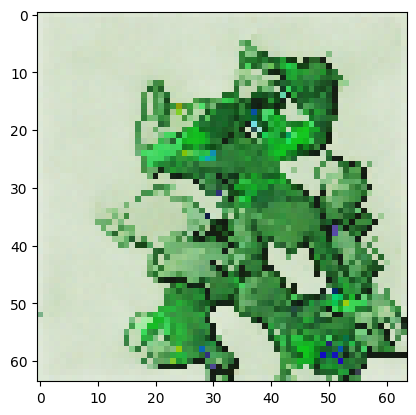

0.03557402:  34%|███▍      | 34499/100001 [48:07<1:24:38, 12.90it/s]

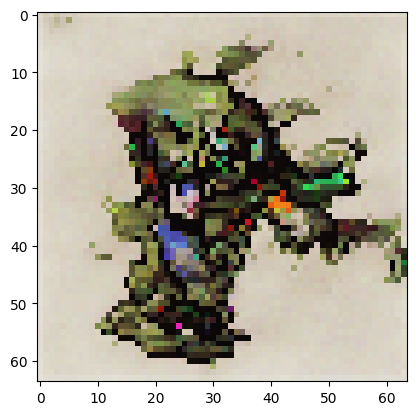

0.04515290:  35%|███▍      | 34999/100001 [48:48<1:23:55, 12.91it/s]

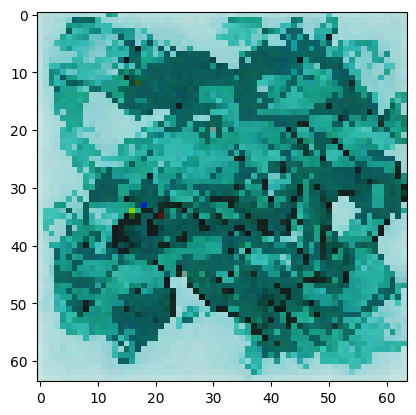

0.01537488:  35%|███▌      | 35499/100001 [49:30<1:23:15, 12.91it/s]

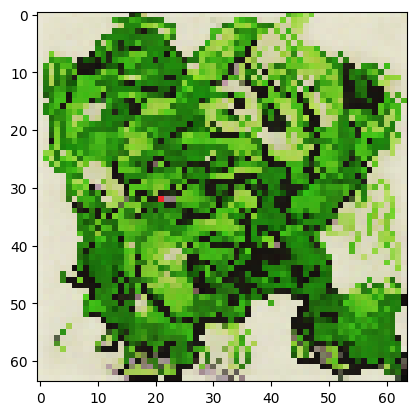

0.05746248:  36%|███▌      | 35999/100001 [50:12<1:22:36, 12.91it/s]

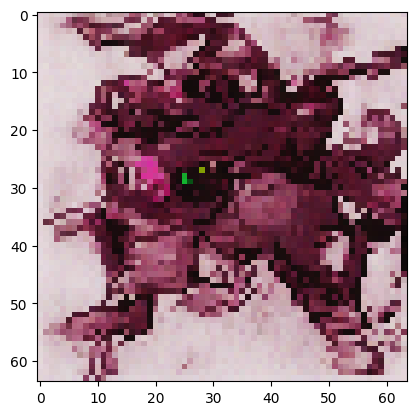

0.05349057:  36%|███▋      | 36499/100001 [50:54<1:21:44, 12.95it/s]

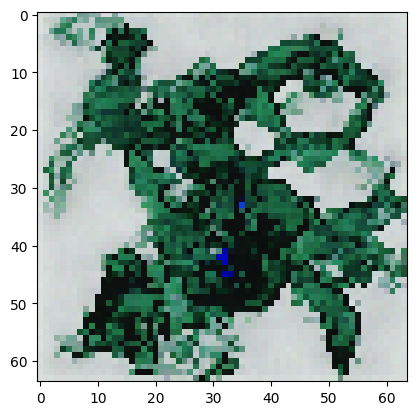

0.03063549:  37%|███▋      | 36999/100001 [51:35<1:21:12, 12.93it/s]

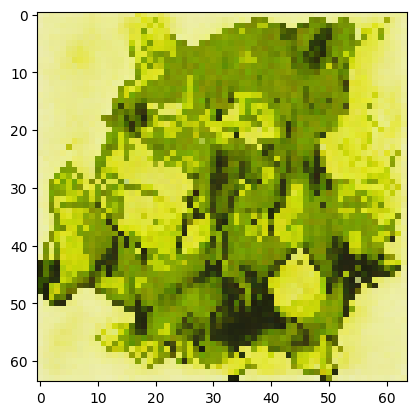

0.05525872:  37%|███▋      | 37499/100001 [52:17<1:20:39, 12.91it/s]

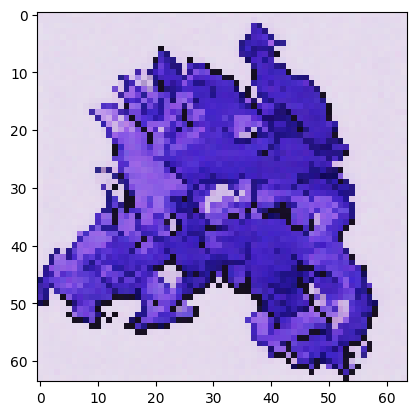

0.02936891:  38%|███▊      | 37999/100001 [52:59<1:20:05, 12.90it/s]

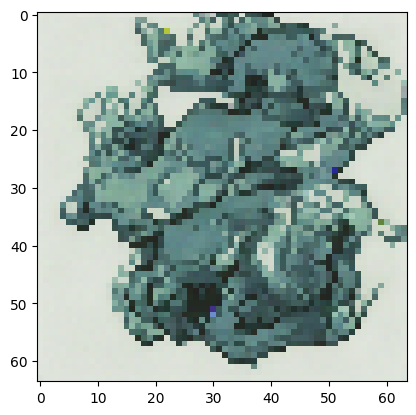

0.03902626:  38%|███▊      | 38499/100001 [53:40<1:19:28, 12.90it/s]

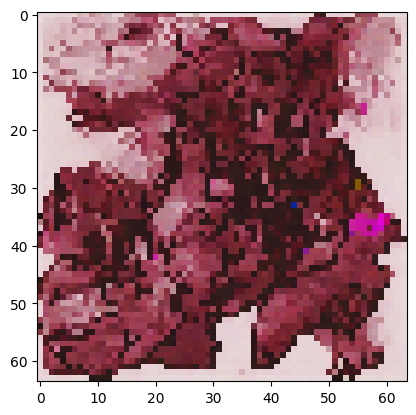

0.02581589:  39%|███▉      | 38999/100001 [54:22<1:18:39, 12.93it/s]

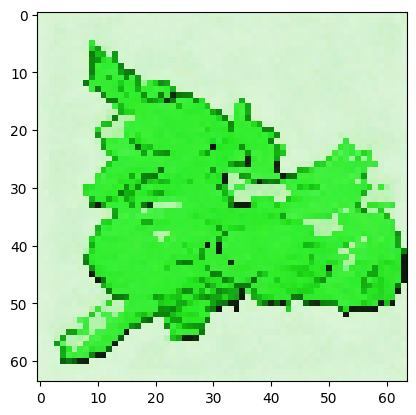

0.02091886:  39%|███▉      | 39499/100001 [55:04<1:18:33, 12.83it/s]

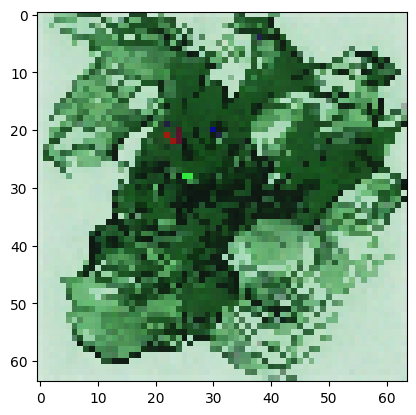

0.02919580:  40%|███▉      | 39999/100001 [55:46<1:17:31, 12.90it/s]

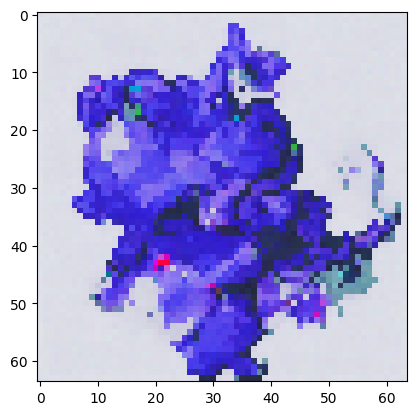

0.02136653:  40%|████      | 40499/100001 [56:27<1:16:49, 12.91it/s]

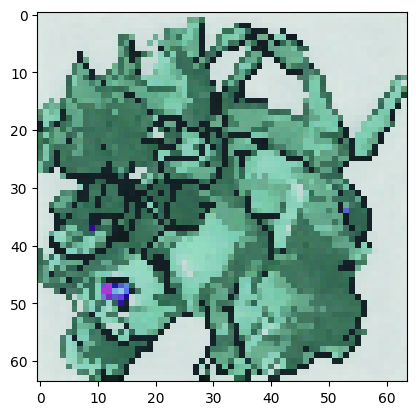

0.03312912:  41%|████      | 40999/100001 [57:09<1:16:10, 12.91it/s]

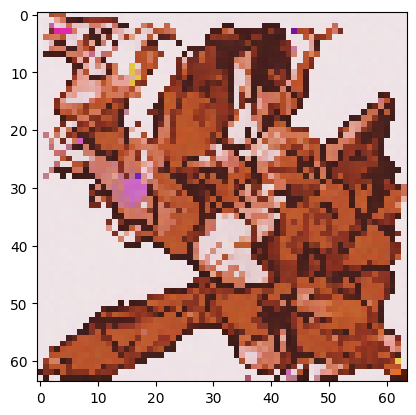

0.04966858:  41%|████▏     | 41499/100001 [57:51<1:15:31, 12.91it/s]

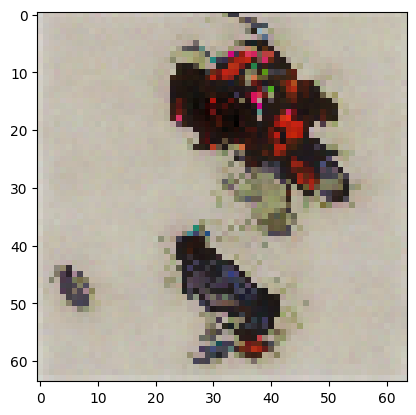

0.05363053:  42%|████▏     | 41999/100001 [58:33<1:14:49, 12.92it/s]

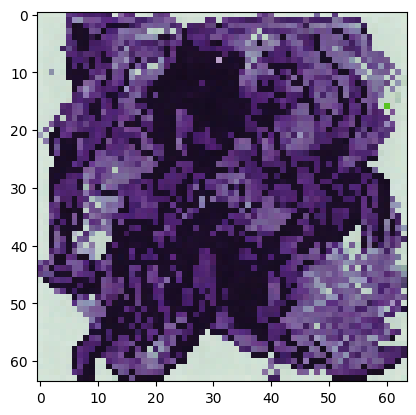

0.02313206:  42%|████▏     | 42499/100001 [59:14<1:14:15, 12.91it/s]

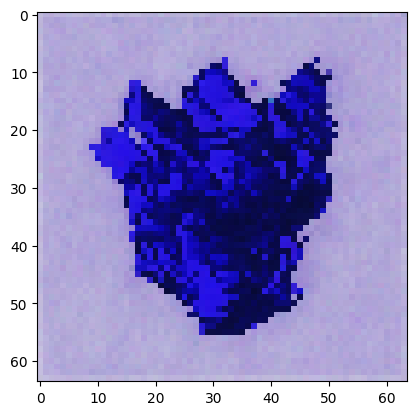

0.02874253:  43%|████▎     | 42999/100001 [59:56<1:13:40, 12.89it/s]

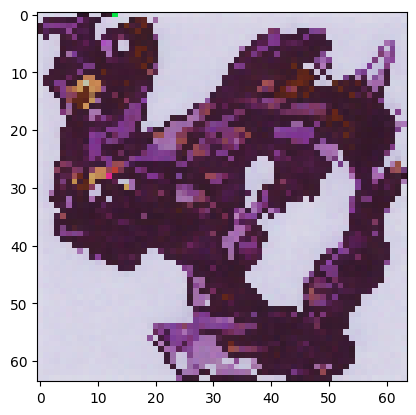

0.01626576:  43%|████▎     | 43499/100001 [1:00:38<1:13:10, 12.87it/s]

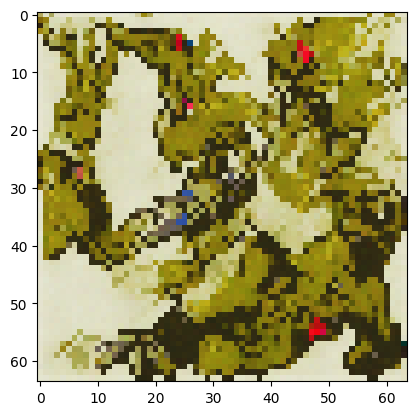

0.04863711:  44%|████▍     | 43999/100001 [1:01:20<1:12:26, 12.88it/s]

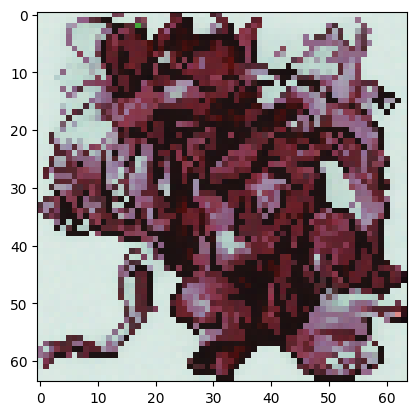

0.05202033:  44%|████▍     | 44499/100001 [1:02:01<1:11:38, 12.91it/s]

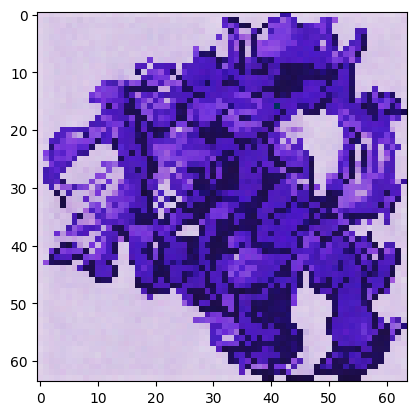

0.04200371:  45%|████▍     | 44999/100001 [1:02:43<1:11:16, 12.86it/s]

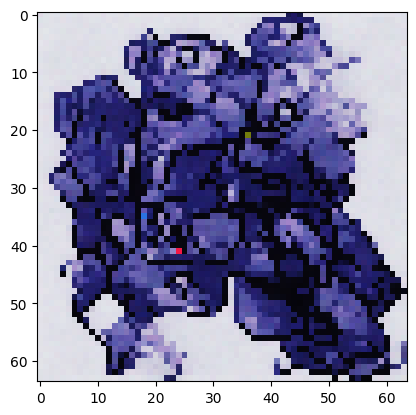

0.03963269:  45%|████▌     | 45499/100001 [1:03:27<1:10:17, 12.92it/s]

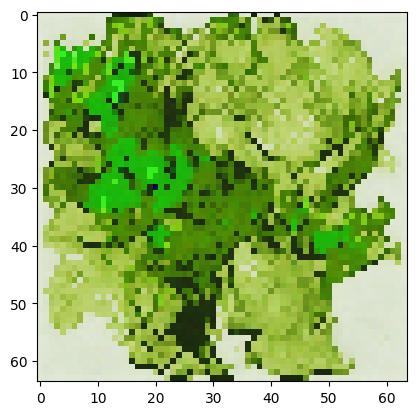

0.04495344:  46%|████▌     | 45999/100001 [1:04:08<1:09:53, 12.88it/s]

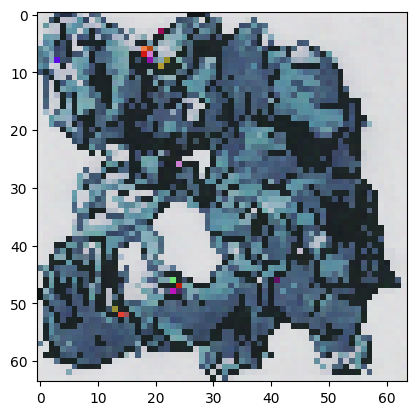

0.04311573:  46%|████▋     | 46499/100001 [1:04:50<1:09:00, 12.92it/s]

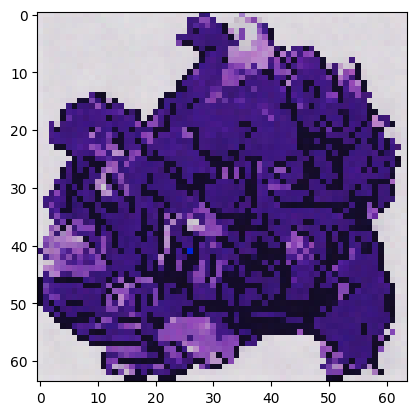

0.03138059:  47%|████▋     | 46999/100001 [1:05:32<1:08:18, 12.93it/s]

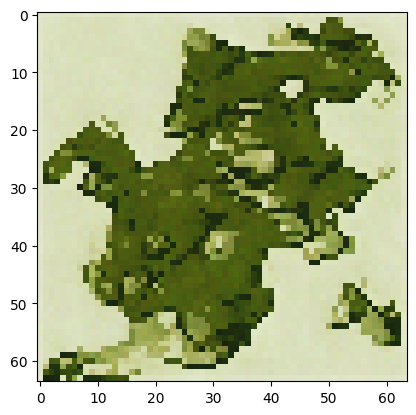

0.03198755:  47%|████▋     | 47499/100001 [1:06:13<1:07:49, 12.90it/s]

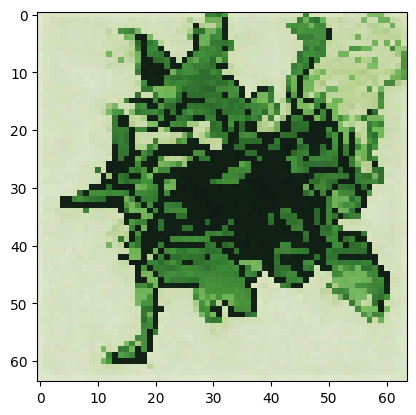

0.04051983:  48%|████▊     | 47999/100001 [1:06:55<1:06:54, 12.95it/s]

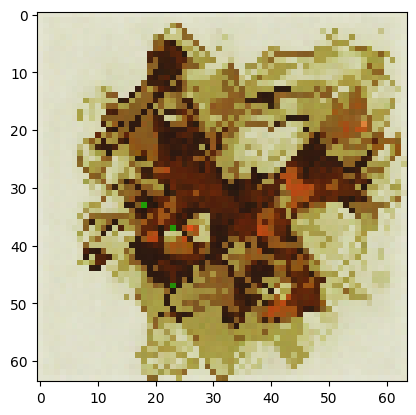

0.02732326:  48%|████▊     | 48499/100001 [1:07:37<1:06:23, 12.93it/s]

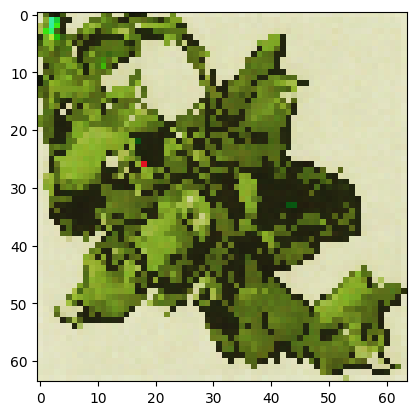

0.01694755:  49%|████▉     | 48999/100001 [1:08:19<1:05:57, 12.89it/s]

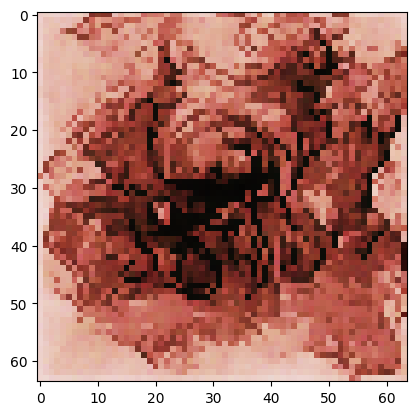

0.02662601:  49%|████▉     | 49499/100001 [1:09:00<1:05:15, 12.90it/s]

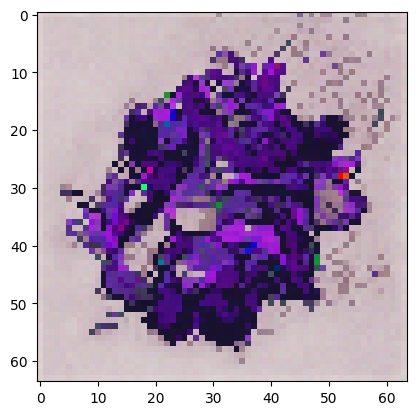

0.03469077:  50%|████▉     | 49999/100001 [1:09:42<1:04:29, 12.92it/s]

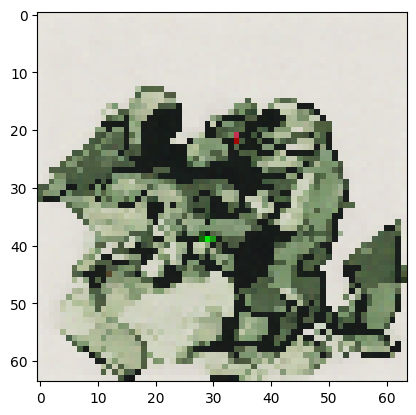

0.02476951:  50%|█████     | 50499/100001 [1:10:24<1:03:45, 12.94it/s]

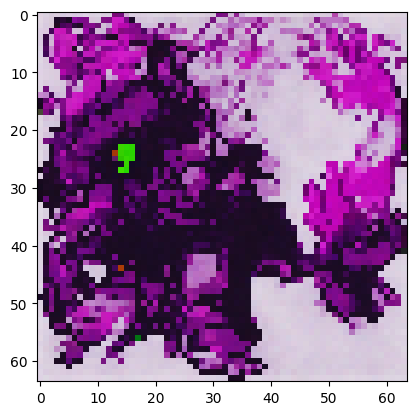

0.03757543:  51%|█████     | 50999/100001 [1:11:06<1:03:10, 12.93it/s]

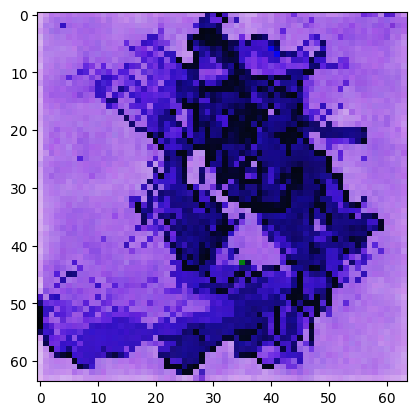

0.02029058:  51%|█████▏    | 51499/100001 [1:11:47<1:02:56, 12.84it/s]

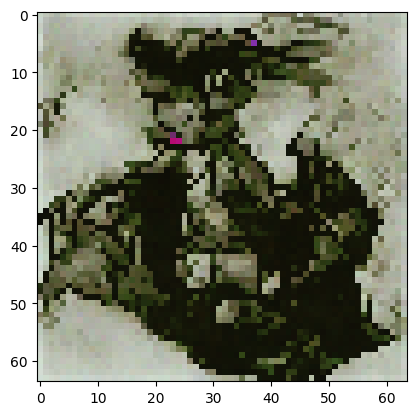

0.03696530:  52%|█████▏    | 51999/100001 [1:12:29<1:01:58, 12.91it/s]

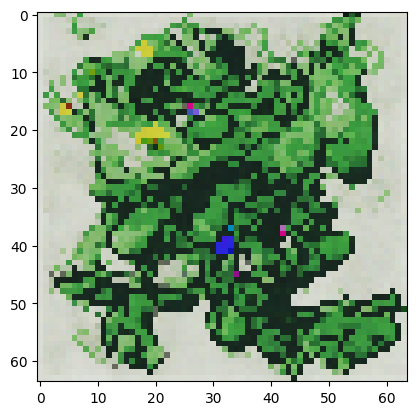

0.03066356:  52%|█████▏    | 52499/100001 [1:13:11<1:01:19, 12.91it/s]

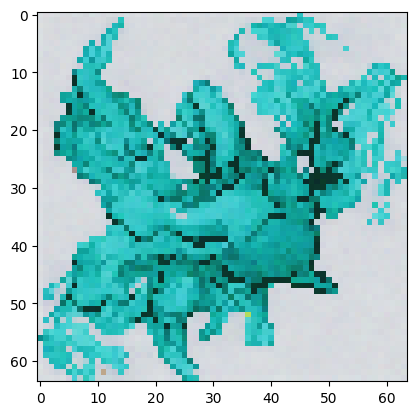

0.03162588:  53%|█████▎    | 52999/100001 [1:13:52<1:00:56, 12.85it/s]

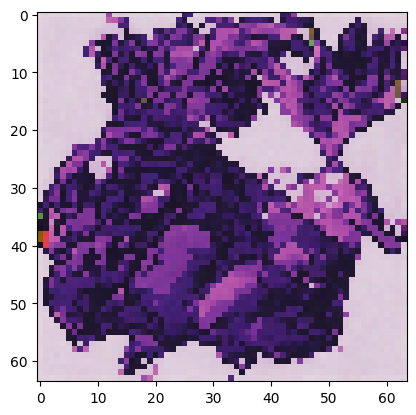

0.02766622:  53%|█████▎    | 53499/100001 [1:14:34<1:00:01, 12.91it/s]

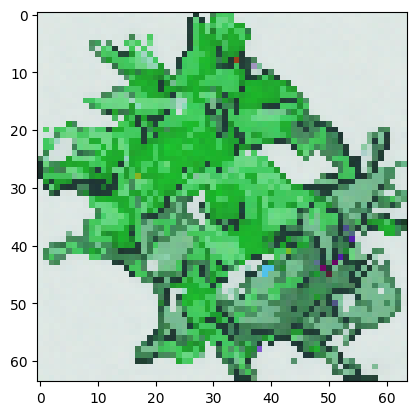

0.03606541:  54%|█████▍    | 53999/100001 [1:15:16<59:15, 12.94it/s]  

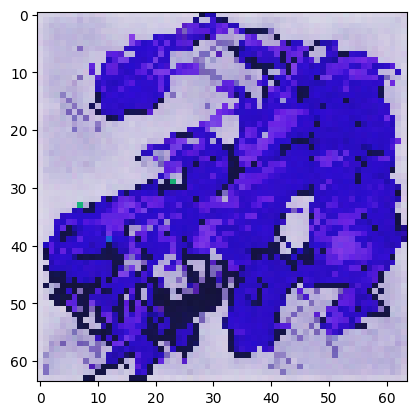

0.02391430:  54%|█████▍    | 54499/100001 [1:15:58<58:40, 12.92it/s]  

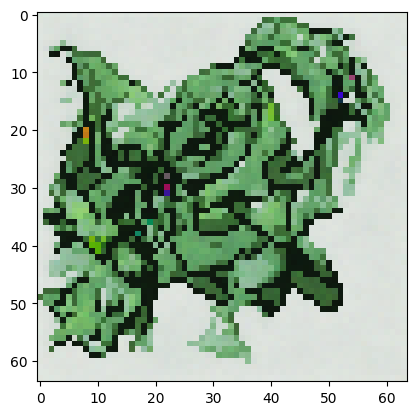

0.04848091:  55%|█████▍    | 54999/100001 [1:16:39<57:55, 12.95it/s]  

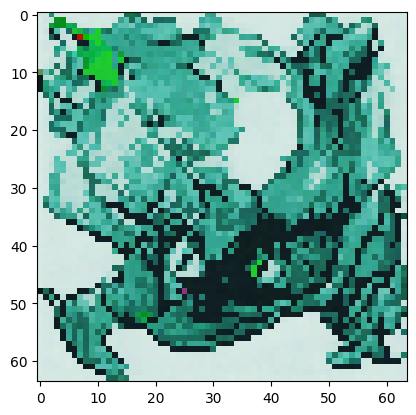

0.03908157:  55%|█████▌    | 55053/100001 [1:16:47<1:02:41, 11.95it/s]


KeyboardInterrupt: 

In [8]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))#, miniters=15)
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)
    
    e = torch.randn(x0.shape, device=device)
    t = torch.randint(0, T - 1, (bs,), device=device)

    x_nois = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    #xc = contour[source, batch]
    #xn = torch.cat([x_nois, xc], dim=1)

    e_pred = model(x_nois, t)

    # Calculate the loss between the result and the noise
    loss = loss_func(e, e_pred)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 500 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')